# Recurrent Neural Network - Word Classification
### Using Seq2Seq model
Created in TensorFlow

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2

%matplotlib notebook

# Creating CSV
import glob
import csv

# Display Graph
from IPython.display import clear_output, Image, display, HTML

# Helpers
from ocr.helpers import implt
from ocr.mlhelpers import TrainingPlot, DataSet

print("OpenCV: " + cv2.__version__)
print("Numpy: " + np.__version__)
print("TensorFlow: " + tf.__version__)

OpenCV: 3.1.0
Numpy: 1.12.1
TensorFlow: 1.1.0


In [2]:
def sofmaxLabels(lab, clas):
    """ Transform labels for sofmax classification """
    newLab = np.zeros((len(lab), clas), dtype=np.int8)
    for i in range(len(lab)):
        newLab[i][int(lab[i][0])] = 1
    return newLab

### Global Variables

In [3]:
LANG = 'en'

## Load Images and Lables in CSV

In [4]:
EN_CLAS = 53
CZ_CLAS = 83
CLAS = 53

if LANG == 'en':
    CLAS = EN_CLAS
elif LANG == 'cz':
    CLAS = CZ_CLAS

# dimension 64x64 = 4096
images = np.genfromtxt('data/charclas/' + LANG + '-data.csv', delimiter=',')
labels = np.genfromtxt('data/charclas/' + LANG + '-labels.csv', delimiter=',')
labels = np.reshape(labels, (len(labels), 1))

# Regularization of images
images[images < 40] = 0
images = images.astype(np.float32)
images = np.multiply(images, 1.0 / 255.0)

print("CSV data files loaded.")
print("Number of images: " + str(len(images)))

# Splitting into train and test data
div = int(0.80 * len(images))

# Transform labels for sofmax output
llabels = sofmaxLabels(labels, CLAS)

trainData = images[0:div]
evalData = images[div:]

trainLabels = llabels[0:div]
evalLabels = llabels[div:]

print("Training images: %g" % div)

CSV data files loaded.
Number of images: 2607
Training images: 2085


# Create classifier

### Dataset

In [5]:
# Prepare training dataset
trainSet = DataSet(trainData, trainLabels)

## Recurrent Neural Network

### Graph

In [ ]:
# RNN getting startd

# TODO Create data: train, test

# Data iterator for feeding batches
class DataIterator():
    """ Class for shuffling and feeding data in batches """
    def __init__(self, df):
        # TODO update data input format
        self.df = df
        self.size = len(self.df)
        self.epochs = 0
        self.shuffle()

    def shuffle(self):
        self.df = self.df.sample(frac=1).reset_index(drop=True)
        self.cursor = 0

    def next_batch(self, n):
        """
        Returns n size batch of data containing [sequences, results, lengths]
        seqences are padded by 0 to max sequence length
        """
        if self.cursor+n > self.size:
            self.epochs += 1
            self.shuffle()
        res = self.df.ix[self.cursor:self.cursor+n-1]
        self.cursor += n

        # Pad sequences with 0s so they are all the same length
        # TODO maybe use special padd simbol
        # TODO solve padding of 2D image
        maxlen = max(res['length'])
        x = np.zeros([n, maxlen], dtype=np.int32)
        for i, x_i in enumerate(x):
            x_i[:res['length'].values[i]] = res['as_numbers'].values[i]

        return x, res['gender']*3 + res['age_bracket'], res['length']
    
    
data = DataIterator(train)
# DEBUG
d = data.next_batch(3)
print('Input sequences\n', d[0], end='\n\n')
print('Target values\n', d[1], end='\n\n')
print('Sequence lengths\n', d[2])

### Old CNN - DELETE

In [7]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

# Functions for initializing convulation and pool layers
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')


# Place holders for data (x) and labels (y_)
x = tf.placeholder(tf.float32, [None, 4096], name="x")
y_ = tf.placeholder(tf.float32, [None, CLAS])

# Reshape data
x_image = tf.reshape(x, [-1, 64, 64, 1])

# 1. Layer - Convulation + Subsampling
W_conv1 = tf.get_variable('W_conv1', shape=[5, 5, 1, 10],
                          initializer=tf.contrib.layers.xavier_initializer())
b_conv1 = tf.Variable(tf.constant(0.1, shape=[10]), name="b_conv1")

h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)    

# 2. Layer - Max Pool
h_pool1 = max_pool_2x2(h_conv1)    

# 3. Layer - Convulation + Subsampling
W_conv2 = tf.get_variable('W_conv2', shape=[5, 5, 10, 20],
                          initializer=tf.contrib.layers.xavier_initializer())
b_conv2 = tf.Variable(tf.constant(0.1, shape=[20]), name="b_conv2")

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)    

# 4. Layer - Max Pool
h_pool2 = max_pool_2x2(h_conv2)    

# 5. Layer - Convulation + Subsampling
W_conv3 = tf.get_variable('W_conv3', shape=[3, 3, 20, 40],
                          initializer=tf.contrib.layers.xavier_initializer())
b_conv3 = tf.Variable(tf.constant(0.1, shape=[40]), name="b_conv3")

h_conv3 = tf.nn.relu(conv2d(h_pool2, W_conv3) + b_conv3)    

# 6. Layer - Max Pool
h_pool3 = max_pool_2x2(h_conv3)

# Reshape filters into flat arraty
h_flat = tf.reshape(h_pool3, [-1, 8*8*40])    

# 7. Fully Connected layer
W_fc1 = tf.get_variable('W_fc1', shape=[8*8*40, 80],
                        initializer=tf.contrib.layers.xavier_initializer())
b_fc1 = tf.Variable(tf.constant(0.1, shape=[80]), name="b_fc1")

h_fc1 = tf.nn.relu(tf.matmul(h_flat, W_fc1) + b_fc1)    

# 8. Dropout
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

# 9. Output layer
W_fc2 = tf.get_variable('W_fc2', shape=[80, CLAS],
                        initializer=tf.contrib.layers.xavier_initializer())
b_fc2 = tf.Variable(tf.constant(0.1, shape=[CLAS]), name="b_fc2")

y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2


# Creating activation function for using the model when imported
activation = tf.argmax(tf.matmul(h_fc1, W_fc2) + b_fc2, 1)
tf.add_to_collection('activation', activation)


# Cost: cross entropy + regularization
# Regularization with L2 Regularization with decaying learning rate
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=y_conv, labels=y_)
beta = 0.1
regularizers = tf.nn.l2_loss(W_fc2) + tf.nn.l2_loss(W_fc1)
cost = tf.reduce_mean(cross_entropy + beta * regularizers)


# Optimizing model parametrs
train_step = tf.train.AdamOptimizer(1e-4).minimize(cost)


# Measuring accuracy of model
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

### Training

<IPython.core.display.Javascript object>


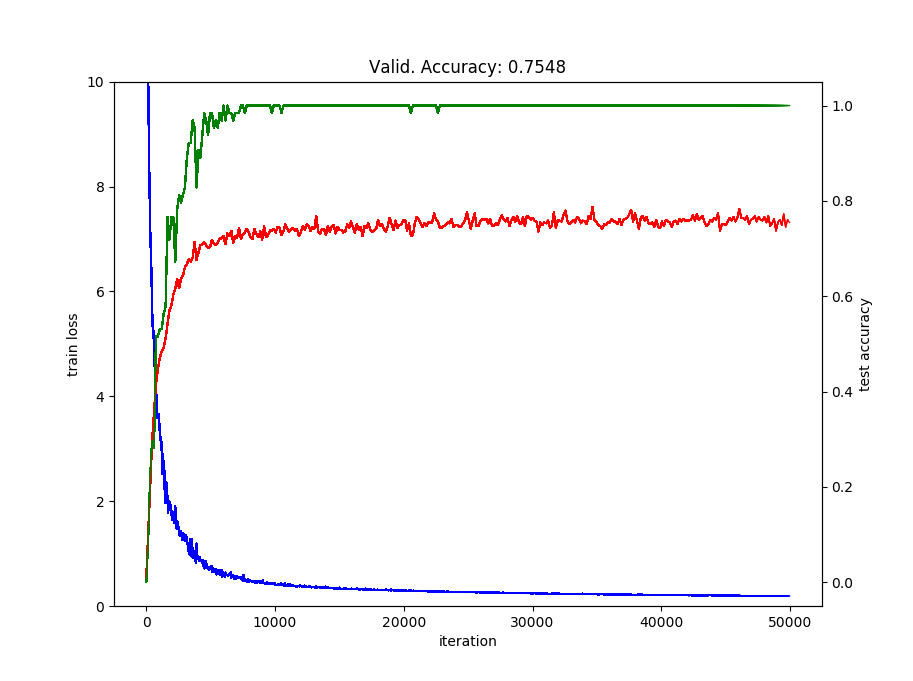

Accuracy 0.754789


In [8]:
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver()

# Set the logs writer to the folder and save graph for Tensorboard
summary_writer = tf.summary.FileWriter('logs', sess.graph)

### SETTINGS  ###
TRAIN_STEPS = 50000
TEST_ITER = 150
COST_ITER = 50
SAVE_ITER = 2000
BATCH_SIZE = 64

# Creat plot for live stats ploting
trainPlot = TrainingPlot(TRAIN_STEPS, TEST_ITER, COST_ITER)

for i in range(TRAIN_STEPS):
    trainBatch, labelBatch = trainSet.next_batch(BATCH_SIZE)

    
    if i%COST_ITER == 0:
        # Plotting cost
        tmpCost = cost.eval(feed_dict={x: trainBatch, y_: labelBatch, keep_prob: 1.0})
        trainPlot.updateCost(tmpCost, i // COST_ITER)
    
    if i%TEST_ITER == 0:
        # Plotting accuracy
        accEval = accuracy.eval(feed_dict={x: evalData, y_: evalLabels, keep_prob: 1.0})
        accTrain = accuracy.eval(feed_dict={x: trainBatch, y_: labelBatch, keep_prob: 1.0})
        trainPlot.updateAcc(accEval, accTrain, i // TEST_ITER)
        
    if i%SAVE_ITER == 0:
        saver.save(sess, 'models/char-clas/' + LANG + '/CharClassifier')

    train_step.run(feed_dict={x: trainBatch, y_: labelBatch, keep_prob: 0.4})

# Final Save
saver.save(sess, 'models/char-clas/' + LANG + '/CharClassifier')

print("Accuracy %g" % accuracy.eval(feed_dict={x: evalData, y_: evalLabels, keep_prob: 1.0}))

sess.close()